In [1]:
# to get equilibirum i need the birth rate to equal the death rate
# equalibrium number = birth rate / death rate
# spontanious emmergence + number * replication chance = n * death chance
# spontanious birth is unrealistic
# birth rate - death rate = 0 at equilibirum

# with reproduction
# delta = SBR + (R - D)*N

# overcrowding causes fewer births and more deaths

# need to make costs for higher max vel
# init_maxvel needs an equasion to make metabolism what init metabolism
# make a tail
# make steering force also evolve

# https://www.youtube.com/watch?v=0ZGbIKd0XrM&t=198s
# https://www.youtube.com/watch?v=KMeT2k1ytYs&t=261s
# https://www.youtube.com/watch?v=dyiZaHIRM6w



In [2]:
import pygame as pg
import time
import random
import math
import numpy as np
from pygame import gfxdraw
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
pg.init()

game_width = 800
game_height = 600
fps = 60

white = (255,255,255)
black = (0,0,0)
red = (255,0,0)
green = (0,255,0)
blue = (0,0,255)
purple = (255,0,255)
cyan = (0,255,255)

spontanious_birth_chance = .0001
spontanious_death_chance = .001
spontanious_food_chance = .4
reproduction_chance = .01
max_creatures = 200
max_food = 500

init_size = 10
init_vel = 2
init_steering_weight = 0.5
init_metabolism = .01
max_vel = 5
age_factor = .0001
mutation_change = .05

food_size = 5

num_starting_creatures = 5
num_starting_food = int(max_food/2)

boundary_size = 40

screen = pg.display.set_mode((game_width,game_height))
clock = pg.time.Clock()

creature_pos = [game_width/2, game_height/2]

In [4]:
def get_draw_pos(x, size):
    pos = x-size/2
    return pos

def magnitude_calc(vector):
    x = 0
    for i in vector:
        x += i**2
    magnitude = x**0.5
    return(magnitude)
    
def normalise(vector):
    magnitude = magnitude_calc(vector)
    if magnitude != 0:
        vector = vector/magnitude
    return(vector)

def check_in_range(n, min, max):
    if n < min:
        return min
    elif n > max:
        return max
    else:
        return n
    
def get_fraction(n, min, max):
    n = check_in_range(n,min,max)
    return n-min/max-min

def health_color_decider(energy):
    health = get_fraction(energy, 0, 2.5)
    color = (max(min((1-health)*255,255),0), max(min(health*255,255),0), 0)
    return(color)

def speed_color_decider(vel):
    legs = get_fraction(vel, 1, 5)
    color = (max(min((legs)*255,255),0), max(min((legs)*255,255),0), 255)
    return(color)

def mutate(n):
    return random.uniform(n-n*mutation_change, n+n*mutation_change)

In [5]:
class create_creature():
    def __init__(self, pos_x, pos_y, size, max_vel):
        self.position = np.array([pos_x,pos_y], dtype='float64')
        self.velocity = np.array([random.uniform(-max_vel,max_vel),random.uniform(-max_vel,max_vel)], dtype='float64') # this seems weird. i think the creature can move fasteer on a diagonal that vertical or horizontal
        self.last_vel = np.array([0,0], dtype='float64')
        self.acceleration = np.array([0, 0], dtype='float64')
        self.metabolism = init_metabolism
        self.energy = 1
        self.perception = 100
        self.max_vel = max_vel
        self.max_force = 0.5
        self.size = size
        self.health_color = health_color_decider(self.energy)
        self.speed_color = speed_color_decider(self.max_vel)
        self.age = 0

    def update(self):
        self.last_vel = self.velocity
        self.velocity = normalise(self.velocity+self.acceleration)*self.max_vel
        self.energy -= self.metabolism
        self.health_color = health_color_decider(self.energy)
        self.position += self.velocity
        self.acceleration *= 0
        self.age += 1

    def apply_force(self, force):
        self.acceleration += force

    def seek(self, target):
        desired_vel = normalise(np.add(target, -self.position))*self.max_vel
        steering_force = np.add(desired_vel, -self.velocity)
        steering_force = normalise(steering_force)*self.max_force
        return(steering_force)
    
    def eat(self, food):
        closest = None
        closest_distance = max(game_width, game_height)
        pos_x = self.position[0]
        pos_y = self.position[1]
        item_number = len(food)-1
        for i in food[::-1]:
            item_x = i.position[0]
            item_y = i.position[1]
            distance = math.hypot(pos_x-item_x, pos_y-item_y)
            if distance < self.size/2:
                food.pop(item_number)
                self.energy += 1
            if distance < closest_distance:
                closest_distance = distance
                closest = i.position
            item_number -=1
        if closest_distance < self.perception:
            seek = self.seek(closest)
            seek *= self.perception
            seek = normalise(seek)*self.max_force
            self.apply_force(seek)
    
    def reproduce(self, creatures):
        new_vel = check_in_range(mutate(self.max_vel), 1, max_vel)
        creatures.append(create_creature(self.position[0],self.position[1], self.size, new_vel))
        self.energy *= .5
    
    def die(self, creatures):
        creatures.remove(self)
 
    def boundaries(self):
        desired = None
        x_pos = self.position[0]
        y_pos = self.position[1]
        if x_pos < boundary_size:
            desired = np.array([self.max_vel, self.velocity[1]])
        elif x_pos > game_width - boundary_size:
            desired = np.array([-self.max_vel, self.velocity[1]])
        if y_pos < boundary_size:
            desired = np.array([self.velocity[0], self.max_vel])
        elif y_pos > game_height - boundary_size:
            desired = np.array([self.velocity[0], -self.max_vel])
        if desired is not None:
            steer = desired-self.velocity
            steer = normalise(steer)*self.max_force
            self.apply_force(steer)
            
    def behave(self, creatures, foods):
        energized = False
        feelin_it = False
        aged = False
        sickly = False
        hungry = True
        depleted = False
        pop_avail = True

#         Definers
        if self.energy > 3:
            energized = True        
        if random.random() < reproduction_chance:
            feelin_it = True
        if self.age > 500:
            aged = True
        if random.random() < spontanious_death_chance:
            sickly = True
        if self.energy > 5:
            hungry = False
        if self.energy <= 0:
            depleted = True
        if len(creatures) > max_creatures:
            pop_avail = False

#         Behaviors
        if energized and feelin_it and not aged and pop_avail:
            self.reproduce(creatures)
        if hungry:
            self.eat(foods)
        if aged:
            self.metabolism *= age_factor
        if sickly or depleted:
            self.die(creatures)
        self.boundaries()
        self.update()

    def draw(self):
        draw_left_x = get_draw_pos(self.position[0],self.size)
        draw_top_y = get_draw_pos(self.position[1],self.size)
        
        def draw_tail():
            if self.age > 0:
                point1 = ((self.position[0]-self.velocity[0]*(self.size/(1.75*self.max_vel))), (self.position[1]-self.velocity[1]*(self.size/(1.75*self.max_vel))))
                pg.draw.line(screen, self.health_color, (self.position[0], self.position[1]), point1, int(self.size/1.5))
                if self.age > 400:
                    point2 = ((self.position[0]-self.last_vel[0]*(self.size/(1.5*self.max_vel))), (self.position[1]-self.last_vel[1]*(self.size/(1.5*self.max_vel))))
                    pg.draw.line(screen, self.health_color, point1, point2, int(self.size/2))
                    if self.age > 800:
                        point3 = ((self.position[0]-self.velocity[0]*(self.size/(1.25*self.max_vel))), (self.position[1]-self.velocity[1]*(self.size/(1.25*self.max_vel))))
                        pg.draw.line(screen, self.health_color, point2, point3, int(self.size/2.5))
            
        def draw_head():
            pg.draw.ellipse(screen, self.health_color, (draw_left_x, draw_top_y, self.size, self.size))
            pg.draw.line(screen, red, (self.position[0], self.position[1]), ((self.position[0]+self.velocity[0]*(self.size/(2.5*self.max_vel))), (self.position[1]+self.velocity[1]*(self.size/(2.5*self.max_vel)))), int(self.size/3))
        
#         draw_tail()
        draw_head()



In [6]:
class create_food():
    def __init__(self, pos_x, pos_y):
        self.position = np.array([pos_x,pos_y], dtype='float64')
    
    def draw(self):
        pg.draw.ellipse(screen, purple, (get_draw_pos(self.position[0],food_size), get_draw_pos(self.position[1],food_size), food_size, food_size))
    

In [7]:
def spontanious_birth(pop):
    pop.append(create_creature(random.uniform(0,game_width), random.uniform(0,game_height), init_size, init_vel))

def spontanious_food(food):
    food.append(create_food(random.uniform(0,game_width), random.uniform(0,game_height)))
    
def initialize(creatures, food):
    for _ in range(num_starting_creatures):
        spontanious_birth(creatures)

    for _ in range(num_starting_food):
        spontanious_food(foods)

def turn_actions(creatures, food):
    pop_avail = True
    miraculous = False
    food_space = True
    food_spawn = False

    if len(creatures) > max_creatures:
        pop_avail = False        
    if random.random() < spontanious_birth_chance:
        miraculous = True
    if len(foods) > max_food:
        food_room = False
    if random.random() < spontanious_food_chance:
        food_spawn = True

    if food_spawn and food_space:
        spontanious_food(foods)
    if miraculous and pop_avail:
        spontanious_birth(creatures)

    for food in foods:
        food.draw()

    for creature in creatures:
        creature.behave(creatures, foods)
        creature.draw()
    

EXITED
AxesSubplot(0.125,0.125;0.775x0.755)


SystemExit: 

/Users/jackselbo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


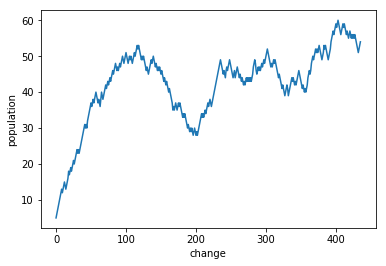

In [8]:
creatures = []
foods = []

initialize(creatures, foods)

pop_tracker = [num_starting_creatures]
time = [0]

game_over = False
while not game_over:
    screen.fill(black)
    
    turn_actions(creatures, foods)

    if len(creatures) != pop_tracker[-1]:
        change = len(pop_tracker)
        pop_tracker.append(len(creatures))
        time.append(pg.time.get_ticks())

    pg.display.update()
    clock.tick(fps)

    for event in pg.event.get():

        if event.type == pg.QUIT:
            game_over == True
            print("EXITED")

            df = pd.DataFrame(list(zip(pop_tracker, range(len(pop_tracker)))), columns = ['population', 'change'])
            df = df.reset_index()

            print(sns.lineplot(x='change', y='population', data=df))

            sys.exit()
pygame.quit()
quit()


In [ ]:
    
            
#         BASIC MOVEMENT (UP, DOWN, LEFT, and RIGHT)
            
#         if event.type == pg.KEYDOWN:
            
#             x = creature_pos[0]
#             y = creature_pos[1]
            
#             if event.key == pg.K_LEFT:
#                 x -= 5
#             if event.key == pg.K_RIGHT:
#                 x += 5
#             if event.key == pg.K_DOWN:
#                 y += 5
#             if event.key == pg.K_UP:
#                 y -= 5
            
#             creature_pos = [x,y]